In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import yaml
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, AutoEmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
from dwave_networkx.algorithms.coloring import min_vertex_color, is_vertex_coloring
import time
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
from graphilp.partitioning import min_vertex_coloring as vtx
from graphilp.imports import networkx as imp_nx

In [31]:
#q_sampler = AutoEmbeddingComposite(DWaveSampler(token='DEV-076b8a03c140ad9291e859ef02ab3403afc91429'))

#### Generate Network

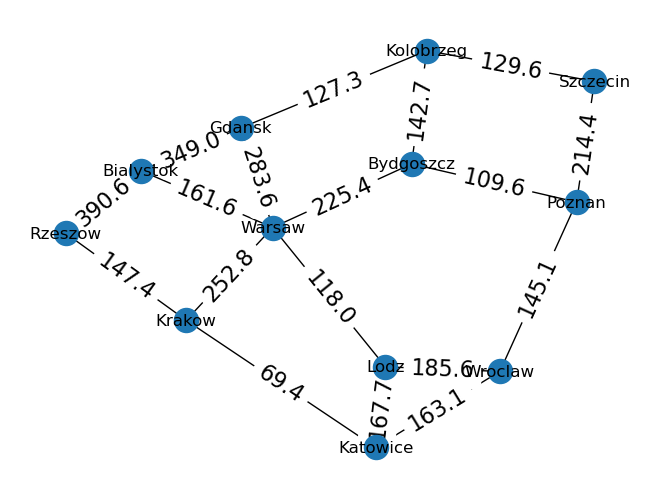

In [6]:
def plot_graph(filename):

    G = nx.read_weighted_edgelist(filename)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels,font_size=16)
    plt.show()
    return G
G=plot_graph("networks/poland.txt")

#### Generate Network Demands

In [ ]:
def generate_demands(G):
    demands = {}
    for a in G.nodes:
        for b in G.nodes:
            if b == a:
                pass
            else:
                x = random.randrange(0, 3, 1)
                if x == 0:
                    demands[(a, b)] = 10
                elif x == 1:
                    demands[(a, b)] = 40
                else:
                    demands[(a, b)] = 100
    return demands
demands = {('Bialystok', 'Bydgoszcz'): 100,
    ('Bialystok', 'Gdansk'): 100,
    ('Bialystok', 'Katowice'): 100,
    ('Bialystok', 'Kolobrzeg'): 100,
    ('Bialystok', 'Krakow'): 10,
    ('Bialystok', 'Lodz'): 100,
    ('Bialystok', 'Poznan'): 40,
    ('Bialystok', 'Rzeszow'): 10,
    ('Bialystok', 'Szczecin'): 10,
    ('Bialystok', 'Warsaw'): 100,
    ('Bialystok', 'Wroclaw'): 10,
    ('Bydgoszcz', 'Gdansk'): 40,
    ('Bydgoszcz', 'Katowice'): 10,
    ('Bydgoszcz', 'Kolobrzeg'): 100,
    ('Bydgoszcz', 'Krakow'): 40,
    ('Bydgoszcz', 'Lodz'): 100,
    ('Bydgoszcz', 'Poznan'): 100,
    ('Bydgoszcz', 'Rzeszow'): 100,
    ('Bydgoszcz', 'Szczecin'): 40,
    ('Bydgoszcz', 'Warsaw'): 40,
    ('Bydgoszcz', 'Wroclaw'): 40,
    ('Gdansk', 'Katowice'): 10,
    ('Gdansk', 'Kolobrzeg'): 100,
    ('Gdansk', 'Krakow'): 10,
    ('Gdansk', 'Lodz'): 40,
    ('Gdansk', 'Poznan'): 40,
    ('Gdansk', 'Rzeszow'): 10,
    ('Gdansk', 'Szczecin'): 100,
    ('Gdansk', 'Warsaw'): 40,
    ('Gdansk', 'Wroclaw'): 10,
    ('Katowice', 'Krakow'): 40,
    ('Katowice', 'Kolobrzeg'): 40,
    ('Katowice', 'Lodz'): 10,
    ('Katowice', 'Poznan'): 100,
    ('Katowice', 'Rzeszow'): 40,
    ('Katowice', 'Szczecin'): 10,
    ('Katowice', 'Warsaw'): 10,
    ('Katowice', 'Wroclaw'): 100,
    ('Kolobrzeg', 'Krakow'): 100,
    ('Kolobrzeg', 'Lodz'): 40,
    ('Kolobrzeg', 'Poznan'): 100,
    ('Kolobrzeg', 'Rzeszow'): 100,
    ('Kolobrzeg', 'Szczecin'): 100,
    ('Kolobrzeg', 'Warsaw'): 40,
    ('Kolobrzeg', 'Wroclaw'): 40,
    ('Krakow', 'Lodz'): 10,
    ('Krakow', 'Poznan'): 40,
    ('Krakow', 'Rzeszow'): 40,
    ('Krakow', 'Szczecin'): 10,
    ('Krakow', 'Warsaw'): 40,
    ('Krakow', 'Wroclaw'): 40,
    ('Lodz', 'Poznan'): 10,
    ('Lodz', 'Rzeszow'): 40,
    ('Lodz', 'Szczecin'): 100,
    ('Lodz', 'Warsaw'): 10,
    ('Lodz', 'Wroclaw'): 10,
    ('Poznan', 'Rzeszow'): 100,
    ('Poznan', 'Szczecin'): 100,
    ('Poznan', 'Warsaw'): 10,
    ('Poznan', 'Wroclaw'): 40,
    ('Rzeszow', 'Szczecin'): 100,
    ('Rzeszow', 'Warsaw'): 100,
    ('Rzeszow', 'Wroclaw'): 10,
    ('Szczecin', 'Warsaw'): 100,
    ('Szczecin', 'Wroclaw'): 100,
    ('Warsaw', 'Wroclaw'): 10
}
demands = {
    ('Bialystok', 'Bydgoszcz'): 100, ('Bydgoszcz', 'Bialystok'): 100,
    ('Bialystok', 'Gdansk'): 100, ('Gdansk', 'Bialystok'): 100,
    ('Bialystok', 'Katowice'): 100, ('Katowice', 'Bialystok'): 100,
    ('Bialystok', 'Kolobrzeg'): 100, ('Kolobrzeg', 'Bialystok'): 100,
    ('Bialystok', 'Krakow'): 10, ('Krakow', 'Bialystok'): 10,
    ('Bialystok', 'Lodz'): 100, ('Lodz', 'Bialystok'): 100,
    ('Bialystok', 'Poznan'): 40, ('Poznan', 'Bialystok'): 40,
    ('Bialystok', 'Rzeszow'): 10, ('Rzeszow', 'Bialystok'): 10,
    ('Bialystok', 'Szczecin'): 10, ('Szczecin', 'Bialystok'): 10,
    ('Bialystok', 'Warsaw'): 100, ('Warsaw', 'Bialystok'): 100,
    ('Bialystok', 'Wroclaw'): 10, ('Wroclaw', 'Bialystok'): 10,

    ('Bydgoszcz', 'Gdansk'): 40, ('Gdansk', 'Bydgoszcz'): 40,
    ('Bydgoszcz', 'Katowice'): 10, ('Katowice', 'Bydgoszcz'): 10,
    ('Bydgoszcz', 'Kolobrzeg'): 100, ('Kolobrzeg', 'Bydgoszcz'): 100,
    ('Bydgoszcz', 'Krakow'): 40, ('Krakow', 'Bydgoszcz'): 40,
    ('Bydgoszcz', 'Lodz'): 100, ('Lodz', 'Bydgoszcz'): 100,
    ('Bydgoszcz', 'Poznan'): 100, ('Poznan', 'Bydgoszcz'): 100,
    ('Bydgoszcz', 'Rzeszow'): 100, ('Rzeszow', 'Bydgoszcz'): 100,
    ('Bydgoszcz', 'Szczecin'): 40, ('Szczecin', 'Bydgoszcz'): 40,
    ('Bydgoszcz', 'Warsaw'): 40, ('Warsaw', 'Bydgoszcz'): 40,
    ('Bydgoszcz', 'Wroclaw'): 40, ('Wroclaw', 'Bydgoszcz'): 40,

    ('Gdansk', 'Katowice'): 10, ('Katowice', 'Gdansk'): 10,
    ('Gdansk', 'Kolobrzeg'): 100, ('Kolobrzeg', 'Gdansk'): 100,
    ('Gdansk', 'Krakow'): 10, ('Krakow', 'Gdansk'): 10,
    ('Gdansk', 'Lodz'): 40, ('Lodz', 'Gdansk'): 40,
    ('Gdansk', 'Poznan'): 40, ('Poznan', 'Gdansk'): 40,
    ('Gdansk', 'Rzeszow'): 10, ('Rzeszow', 'Gdansk'): 10,
    ('Gdansk', 'Szczecin'): 100, ('Szczecin', 'Gdansk'): 100,
    ('Gdansk', 'Warsaw'): 40, ('Warsaw', 'Gdansk'): 40,
    ('Gdansk', 'Wroclaw'): 10, ('Wroclaw', 'Gdansk'): 10,

    ('Katowice', 'Krakow'): 40, ('Krakow', 'Katowice'): 40,
    ('Katowice', 'Kolobrzeg'): 40, ('Kolobrzeg', 'Katowice'): 40,
    ('Katowice', 'Lodz'): 10, ('Lodz', 'Katowice'): 10,
    ('Katowice', 'Poznan'): 100, ('Poznan', 'Katowice'): 100,
    ('Katowice', 'Rzeszow'): 40, ('Rzeszow', 'Katowice'): 40,
    ('Katowice', 'Szczecin'): 10, ('Szczecin', 'Katowice'): 10,
    ('Katowice', 'Warsaw'): 10, ('Warsaw', 'Katowice'): 10,
    ('Katowice', 'Wroclaw'): 100, ('Wroclaw', 'Katowice'): 100,

    ('Kolobrzeg', 'Krakow'): 100, ('Krakow', 'Kolobrzeg'): 100,
    ('Kolobrzeg', 'Lodz'): 40, ('Lodz', 'Kolobrzeg'): 40,
    ('Kolobrzeg', 'Poznan'): 100, ('Poznan', 'Kolobrzeg'): 100,
    ('Kolobrzeg', 'Rzeszow'): 100, ('Rzeszow', 'Kolobrzeg'): 100,
    ('Kolobrzeg', 'Szczecin'): 100, ('Szczecin', 'Kolobrzeg'): 100,
    ('Kolobrzeg', 'Warsaw'): 40, ('Warsaw', 'Kolobrzeg'): 40,
    ('Kolobrzeg', 'Wroclaw'): 40, ('Wroclaw', 'Kolobrzeg'): 40,

    ('Krakow', 'Lodz'): 10, ('Lodz', 'Krakow'): 10,
    ('Krakow', 'Poznan'): 40, ('Poznan', 'Krakow'): 40,
    ('Krakow', 'Rzeszow'): 40, ('Rzeszow', 'Krakow'): 40,
    ('Krakow', 'Szczecin'): 10, ('Szczecin', 'Krakow'): 10,
    ('Krakow', 'Warsaw'): 40, ('Warsaw', 'Krakow'): 40,
    ('Krakow', 'Wroclaw'): 40, ('Wroclaw', 'Krakow'): 40,

    ('Lodz', 'Poznan'): 10, ('Poznan', 'Lodz'): 10,
    ('Lodz', 'Rzeszow'): 40, ('Rzeszow', 'Lodz'): 40,
    ('Lodz', 'Szczecin'): 100, ('Szczecin', 'Lodz'): 100,
    ('Lodz', 'Warsaw'): 10, ('Warsaw', 'Lodz'): 10,
    ('Lodz', 'Wroclaw'): 10, ('Wroclaw', 'Lodz'): 10,

    ('Poznan', 'Rzeszow'): 100, ('Rzeszow', 'Poznan'): 100,
    ('Poznan', 'Szczecin'): 100, ('Szczecin', 'Poznan'): 100,
    ('Poznan', 'Warsaw'): 10, ('Warsaw', 'Poznan'): 10,
    ('Poznan', 'Wroclaw'): 40, ('Wroclaw', 'Poznan'): 40,

    ('Rzeszow', 'Szczecin'): 100, ('Szczecin', 'Rzeszow'): 100,
    ('Rzeszow', 'Warsaw'): 100, ('Warsaw', 'Rzeszow'): 100,
    ('Rzeszow', 'Wroclaw'): 10, ('Wroclaw', 'Rzeszow'): 10,

    ('Szczecin', 'Warsaw'): 100, ('Warsaw', 'Szczecin'): 100,
    ('Szczecin', 'Wroclaw'): 100, ('Wroclaw', 'Szczecin'): 100,

    ('Warsaw', 'Wroclaw'): 10, ('Wroclaw', 'Warsaw'): 10
}

In [34]:
# Cropped demands only show demands for 1 direction
cropped_demands={}
for item in demands:
    if item[1]>item[0]:
        cropped_demands[item]=demands[item]
print(cropped_demands)

{('Bialystok', 'Bydgoszcz'): 100, ('Bialystok', 'Gdansk'): 100, ('Bialystok', 'Katowice'): 100, ('Bialystok', 'Kolobrzeg'): 100, ('Bialystok', 'Krakow'): 10, ('Bialystok', 'Lodz'): 100, ('Bialystok', 'Poznan'): 40, ('Bialystok', 'Rzeszow'): 10, ('Bialystok', 'Szczecin'): 10, ('Bialystok', 'Warsaw'): 100, ('Bialystok', 'Wroclaw'): 10, ('Bydgoszcz', 'Gdansk'): 40, ('Bydgoszcz', 'Katowice'): 10, ('Bydgoszcz', 'Kolobrzeg'): 100, ('Bydgoszcz', 'Krakow'): 40, ('Bydgoszcz', 'Lodz'): 100, ('Bydgoszcz', 'Poznan'): 100, ('Bydgoszcz', 'Rzeszow'): 100, ('Bydgoszcz', 'Szczecin'): 40, ('Bydgoszcz', 'Warsaw'): 40, ('Bydgoszcz', 'Wroclaw'): 40, ('Gdansk', 'Katowice'): 10, ('Gdansk', 'Kolobrzeg'): 100, ('Gdansk', 'Krakow'): 10, ('Gdansk', 'Lodz'): 40, ('Gdansk', 'Poznan'): 40, ('Gdansk', 'Rzeszow'): 10, ('Gdansk', 'Szczecin'): 100, ('Gdansk', 'Warsaw'): 40, ('Gdansk', 'Wroclaw'): 10, ('Katowice', 'Krakow'): 40, ('Katowice', 'Kolobrzeg'): 40, ('Katowice', 'Lodz'): 10, ('Katowice', 'Poznan'): 100, ('Kato

#### Generate graph of routes

462
76068


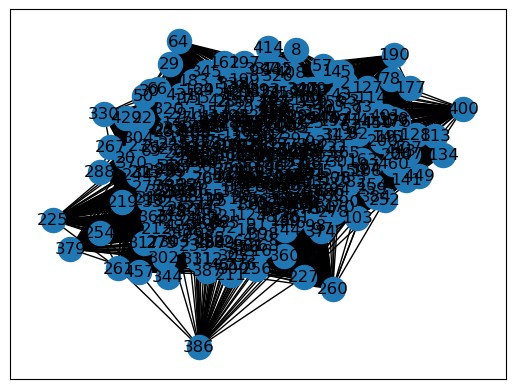

In [5]:
def create_graph(filepath, Graph, demands):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    converted_graph = nx.Graph()
    s_d_label = 0
    label = 0
    for a in network_data:
        s_d_label += 1
        source = network_data[a]["source"]
        destination = network_data[a]["destination"]
        rate = demands[(source, destination)]
        for i in network_data[a]["routes"]:
            label += 1
            nodes_in_path = i
            edges_in_path = []
            total_weight = 0
            for j in range(len(i) - 1):
                edges_in_path.append((nodes_in_path[j], nodes_in_path[j + 1]))
                edges_in_path.append((nodes_in_path[j+1], nodes_in_path[j])) # remove if direction of light matters.
                total_weight += Graph[nodes_in_path[j]][nodes_in_path[j + 1]]["weight"]
            converted_graph.add_node(label, s_d=s_d_label, r=rate,w=total_weight,edges=edges_in_path)
    x=converted_graph.number_of_nodes()
    for a in range(1,x):
        for b in range(a+1,x+1):
            if converted_graph.nodes[a]["s_d"] != converted_graph.nodes[b]["s_d"]: # don't want edge between same connections - then each one affects the others selection
                for j in converted_graph.nodes[a]["edges"]:
                    for i in converted_graph.nodes[b]["edges"]:
                        if i == j:
                            converted_graph.add_edge(a,b)
                            break
                    else:
                        continue
                    break
                        
                        
    return converted_graph

new_graph=create_graph("networks/poland-conversion.yaml",G,demands)
nx.draw_networkx(new_graph)
number_of_nodes=len(new_graph.nodes)
print(number_of_nodes)
print(new_graph.number_of_edges())

In [5]:
max_degree = max(dict(new_graph.degree()).values())
print("Maximum degree:", max_degree)

Maximum degree: 442


#### Write QUBO formulation

In [6]:
def create_qubo(Graph,c1,c2,c3,c4,c5):
    Q={}
    adj_matrix=nx.adjacency_matrix(Graph)
    dense_matrix=adj_matrix.todense()
    set_of_nodes=Graph._node
    for a in set_of_nodes:
        for b in set_of_nodes:
            if Graph.nodes[a]["s_d"]==Graph.nodes[b]["s_d"]:
                if a==b:
                    Q[(a,b)]=-c1
                else:
                    Q[(a,b)]=2*c1
            elif dense_matrix[a-1][b-1]==1:
                Q[(a,b)]=c2
            else:
                Q[(a,b)]=0
    
    for a in set_of_nodes:
        Q[(a,a)]+= Graph.degree(a)*c5
        length=Graph.nodes[a]["w"]  
        Q[(a,a)]+=c4*length
        if Graph.nodes[a]["r"]==10:
            max_d=1680
        elif Graph.nodes[a]["r"]==40:
            max_d=1170
        else:
            max_d=1060
        if length>max_d:
            Q[(a,a)]+=c3


    return Q
            
QUBO = create_qubo(new_graph,4,0.04,4,0,0.0003)
bqm= BinaryQuadraticModel.from_qubo(QUBO)

#### Solve with SA/QA

In [7]:
def solve_qubo(bqm,sampler=SimulatedAnnealingSampler(),num_runs=1):
    sampleset= sampler.sample(bqm,num_reads=num_runs,label= "Routing QUBO solving")
    return sampleset

result=solve_qubo(bqm)
print(result)
for variable in range(1,number_of_nodes+1):
    print(int(result.first.sample[variable]))

   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 462    energy num_oc.
0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0 ...   0 -209.1518       1
['BINARY', 1 rows, 1 samples, 462 variables]
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0

#### Solve with Gurobi

In [ ]:
def solve_qubo_with_gurobi(Q,time_limit=10):
    # Create a Gurobi model
    model = Model("QUBO")

    # Suppress Gurobi output
    model.setParam('OutputFlag', 0)
    
    # Set a time limit (in seconds)
    model.setParam('TimeLimit', time_limit)

    # Extract variables from QUBO keys
    variables = set(i for i, j in Q.keys()).union(set(j for i, j in Q.keys()))

    # Add binary variables to the model
    x = {v: model.addVar(vtype=GRB.BINARY, name=f'x_{v}') for v in variables}

    # Add the QUBO objective function
    model.setObjective(
        quicksum(Q[i, j] * x[i] * x[j] for i, j in Q.keys()),
        GRB.MINIMIZE
    )
    # Measure the runtime
    start_time = time.time()
    model.optimize()
    end_time = time.time()

    # Calculate runtime
    runtime = end_time - start_time


    # Extract the solution
    if model.status == GRB.OPTIMAL:
        solution = {v: int(x[v].x) for v in variables}
        objective_value = model.objVal
        return solution, objective_value,runtime
    else:
        return None, None
#gurobi_sol=solve_qubo_with_gurobi(QUBO)
#print(gurobi_sol)

Set parameter Username
Set parameter LicenseID to value 2690074
Academic license - for non-commercial use only - expires 2026-07-22
(None, None)


In [ ]:
gurobi_table=[]
# Produce Gurobi output as a list
if gurobi_sol!= (None,None):
    for i in range(1,number_of_nodes+1):
        gurobi_table.append(gurobi_sol[0][i])
print(gurobi_table)


[]


#### Check if solution is valid

In [8]:
def is_valid_solution(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=[]
    total_length=0
    for i in range(1,number_of_nodes+1):
        solution_results.append(int(result.first.sample[i]))
        if int(result.first.sample[i])==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]

def is_valid_solution_gurobi(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=result
    total_length=0
    for i in range(1,number_of_routes[-1]+1):
        if solution_results[i-1]==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]
    
print(is_valid_solution(result,"networks/poland-conversion.yaml",new_graph))
#print(is_valid_solution_gurobi(gurobi_table,"networks/poland-conversion.yaml",new_graph))


[True, 34480.99999999999]


#### Is Solution Same as Gurobi

In [9]:
solution_values=[]
for variable in range(1,number_of_nodes+1):
    solution_values.append(int(result.first.sample[variable]))
#print(solution_values==gurobi_table)
#for variable in range(1,number_of_nodes+1):
    #if not solution_values[variable-1]==gurobi_table[variable-1]:
        #print(variable)

#### Generate Reduced Graph

66


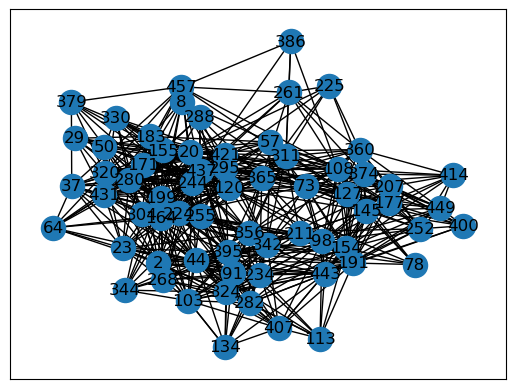

In [10]:
reduced_graph=create_graph("networks/poland-conversion.yaml",G,demands)
for i in range(number_of_nodes):
    if solution_values[i]==0:
        reduced_graph.remove_node(i+1)

pos = nx.spring_layout(G, k=100, iterations=100)
nx.draw_networkx(reduced_graph)
print(reduced_graph.number_of_nodes())


In [11]:
print(reduced_graph.number_of_edges())
max_degree = max(dict(reduced_graph.degree()).values())
print("Maximum degree:", max_degree)

629
Maximum degree: 32


#### Graph colouring Gurobi

In [ ]:
def solve_graph_coloring_gurobi(Graph):
    edges = list(Graph.edges)
    G = imp_nx.read(Graph)
    # List of edges (each edge represented as a tuple of nodes)
    

    # Create a Gurobi environment with output suppressed
    env = gp.Env(empty=True)
    env.setParam('OutputFlag', 0)  # Suppress output
    env.start()
    
    # Create the model using vtx.create_model
    mdl = vtx.create_model(G)

    # Optimize the model
    start_time = time.time()
    mdl.optimize()
    end_time = time.time()

    # Extract the solution using the provided function
    color_to_node, node_to_color = vtx.extract_solution(G, mdl)

    if mdl.status == GRB.OPTIMAL:
        # Use the extracted solution to build the color_map
        color_map = {node: color for color, nodes in color_to_node.items() for node in nodes}
        used_colors = set(color_map.values())

        # Verify that no two adjacent nodes have the same color
        valid = True
        for (i, j) in edges:
            if color_map[i] == color_map[j]:
                valid = False
                break  # No need to continue if an invalid pair is found

        return {
            "valid": valid,
            "num_colors": len(used_colors),
            "time_taken": end_time - start_time,
            "color_map": color_map
        }
    else:
        return {
            "valid": False,
            "num_colors": None,
            "time_taken": end_time - start_time
        }

colouring=solve_graph_coloring_gurobi(reduced_graph)
def draw_colored_graph(Graph, color_map):
    pos = nx.spring_layout(Graph)
    colors = [color_map[node] for node in Graph.nodes()]
    nx.draw(Graph, pos, with_labels=True, node_color=colors, cmap=plt.cm.get_cmap('tab20'))
draw_colored_graph(reduced_graph,colouring["color_map"])

Set parameter Username
Set parameter LicenseID to value 2690074
Academic license - for non-commercial use only - expires 2026-07-22
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 3 4300U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 45671 rows, 4422 columns and 141106 nonzeros
Model fingerprint: 0x46e1ff81
Variable types: 0 continuous, 4422 integer (4422 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 66.0000000


KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\victo\miniforge3\Lib\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 


Presolve time: 1.67s
Presolved: 44339 rows, 4420 columns, 137452 nonzeros
Variable types: 0 continuous, 4420 integer (4420 binary)
Root relaxation presolved: 4420 rows, 48759 columns, 141872 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    5530    3.7333168e+00   2.012178e+02   0.000000e+00      5s
    6903    3.7333333e+00   0.000000e+00   0.000000e+00      6s
    6903    3.7333333e+00   0.000000e+00   0.000000e+00      6s
    6903    3.7333333e+00   0.000000e+00   0.000000e+00      6s

Root relaxation: objective 3.733333e+00, 6903 iterations, 3.37 seconds (2.99 work units)
Total elapsed time = 10.88s (DegenMoves)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.73333    0  196   66.00000    3.73333  94.3%     -   15s


#### LDF Greedy Colouring

In [12]:
def solve_graph_coloring_networkx(G):
    start_time = time.time()
    nx_coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    end_time = time.time()

    nx_colors_used = len(set(nx_coloring.values()))

    return {
        "valid": True,  # Greedy algorithm should provide a valid coloring
        "num_colors": nx_colors_used,
        "time_taken": end_time - start_time,
        "coloring": nx_coloring
    }
 
colouring=solve_graph_coloring_networkx(reduced_graph)
print(colouring)

{'valid': True, 'num_colors': 13, 'time_taken': 0.0007662773132324219, 'coloring': {244: 0, 342: 1, 224: 0, 295: 2, 164: 3, 255: 4, 280: 1, 120: 5, 395: 3, 73: 0, 98: 1, 108: 3, 421: 6, 437: 5, 44: 2, 199: 7, 356: 2, 154: 4, 155: 8, 171: 4, 234: 6, 443: 5, 191: 7, 304: 9, 320: 9, 324: 8, 431: 10, 2: 7, 20: 6, 91: 9, 145: 8, 365: 7, 374: 9, 183: 11, 282: 10, 103: 11, 207: 10, 23: 8, 311: 8, 268: 12, 360: 5, 57: 9, 37: 11, 50: 3, 177: 4, 252: 6, 407: 0, 449: 2, 127: 11, 457: 2, 29: 4, 64: 5, 134: 4, 261: 1, 330: 7, 8: 1, 113: 9, 344: 5, 400: 1, 414: 7, 211: 3, 288: 0, 379: 3, 78: 0, 225: 2, 386: 0}}


#### SA for colouring

In [23]:
def solve_graph_coloring_annealing(G, sampler, attempts=30):
    start_time = time.time()
    for i in range(attempts):        
        solution = min_vertex_color(G, sampler=sampler, label="GCP")
        try:
            if is_vertex_coloring(G, solution):
                end_time = time.time()
                wavelengths = len(set(solution.values()))
                return {
                    "valid": True,
                    "num_colors": wavelengths,
                    "time_taken": end_time - start_time,
                    "solution": solution
                }
            print(f"[-] Attempt {i} failed")
        except KeyError:
            continue
    return "timeout"
colouring=solve_graph_coloring_annealing(reduced_graph,SimulatedAnnealingSampler())
print(colouring)

{'valid': True, 'num_colors': 22, 'time_taken': 1.9812736511230469, 'solution': {2: 9, 8: 4, 20: 8, 23: 4, 29: 2, 37: 1, 49: 7, 50: 5, 60: 4, 64: 17, 77: 17, 80: 3, 87: 13, 92: 14, 103: 12, 110: 0, 113: 7, 125: 6, 127: 5, 134: 15, 141: 4, 151: 8, 157: 2, 164: 5, 175: 16, 176: 3, 189: 1, 190: 6, 197: 6, 207: 10, 215: 15, 223: 10, 226: 9, 233: 14, 239: 10, 252: 2, 254: 12, 260: 6, 267: 9, 274: 6, 282: 10, 288: 13, 295: 11, 302: 13, 309: 12, 318: 18, 328: 0, 331: 19, 341: 12, 348: 2, 356: 7, 361: 5, 369: 16, 374: 0, 379: 11, 386: 8, 398: 20, 400: 5, 407: 11, 414: 5, 422: 23, 432: 3, 435: 4, 443: 20, 449: 1, 457: 7}}


#### Generate Graph of reduced colouring

Number of colors used: 23


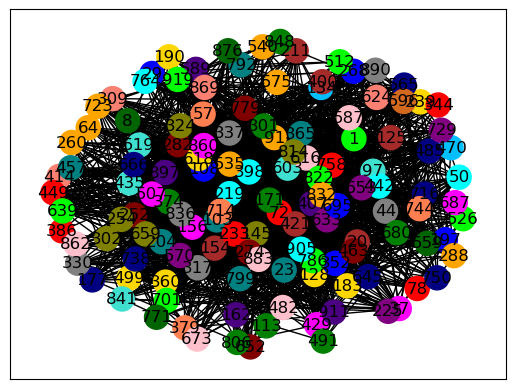

In [ ]:
selected_colours = colouring["coloring"]

colours = [
    "red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan",
    "magenta", "teal", "gold", "navy", "lime", "maroon", "coral", "turquoise", "indigo", "salmon",
    "darkgreen", "deepskyblue", "chocolate", "orchid", "slateblue", "darkorange", "skyblue", "firebrick", "mediumseagreen", "dodgerblue",
    "plum", "lightcoral", "mediumvioletred", "sienna", "khaki", "darkcyan", "steelblue", "crimson", "darkorchid", "mediumturquoise"
]

color_map = [colours[selected_colours[node]] for node in new_graph.nodes()]

print("Number of colors used:", colouring["num_colors"])

pos = nx.spring_layout(reduced_graph, k=3.5, iterations=100)
nx.draw_networkx(reduced_graph, pos=pos, node_color=color_map, with_labels=True)
plt.show()

#### Brute Force Parameter Search

In [ ]:
solve_rate=[]
min_colouring=[]
total_lengths=[]
for i in range(1,5):
    QUBO = create_qubo(new_graph,5,0.044,5,0,0.0001+0.0002*i)
    bqm= BinaryQuadraticModel.from_qubo(QUBO)
    #correct_solution=gurobi_table
    runs=1
    solved_cases=0
    time_taken=0
    colour_dic_SA={}
    for j in range(runs):
        start=time.perf_counter()
        solution=solve_qubo(bqm)
        end=time.perf_counter()
        time_taken+=(end-start)
        solution_outcomes=[]
        for variable in range(1,number_of_nodes+1):
            solution_outcomes.append(solution.first.sample[variable])
        if is_valid_solution(solution,"networks/poland-conversion2.yaml",new_graph)[0]:
            solved_cases+=1
            graph=new_graph.copy()
            total_length=0
            for k in range(number_of_nodes-1):
                if solution_outcomes[k]==0:
                    graph.remove_node(k+1)
                else:
                    total_length+=new_graph.nodes[k+1]["w"]
            coloured=solve_graph_coloring_networkx(graph)
            if coloured["num_colors"] in colour_dic_SA:
                colour_dic_SA[coloured["num_colors"]]+=1
            else:
                colour_dic_SA[coloured["num_colors"]]=1
            
    solve_rate.append(solved_cases/runs)
    if colour_dic_SA=={}:
        min_colouring.append(500)
    else:
        min_colouring.append(min(colour_dic_SA.keys()))
    total_lengths.append(total_length)
    

print(solve_rate)
print(min_colouring)
print(total_lengths)

In [ ]:
a = 4
b = 15
def reshape_list(lst, a, b):
    if len(lst) != a * b:
        raise ValueError(f"List must have exactly {a * b} elements (got {len(lst)})")
    return [lst[i * b:(i + 1) * b] for i in range(a)]
solve_rate = [0] * (a * b)
min_colouring = [0] * (a * b)
total_lengths = [0] * (a * b)
solve_rate_matrix = reshape_list(solve_rate, a, b)
min_colouring_matrix = reshape_list(min_colouring, a, b)
total_lengths_matrix = reshape_list(total_lengths, a, b)
for i in range(0,a):
    for j in range(0,b):
        QUBO = create_qubo(new_graph,5,0.042+0.001*i,4,0,0.0005+0.0002*j)
        bqm= BinaryQuadraticModel.from_qubo(QUBO)
        #correct_solution=gurobi_table
        runs=2
        solved_cases=0
        time_taken=0
        colour_dic_SA={}
        for k in range(runs):
            start=time.perf_counter()
            solution=solve_qubo(bqm)
            end=time.perf_counter()
            time_taken+=(end-start)
            solution_outcomes=[]
            for variable in range(1,number_of_nodes+1):
                solution_outcomes.append(solution.first.sample[variable])
            if is_valid_solution(solution,"networks/poland-conversion.yaml",new_graph)[0]:
                solved_cases+=1
                graph=new_graph.copy()
                total_length=0
                for l in range(number_of_nodes-1):
                    if solution_outcomes[l]==0:
                        graph.remove_node(l+1)
                    else:
                        total_length+=new_graph.nodes[l+1]["w"]
                coloured=solve_graph_coloring_networkx(graph)
                if coloured["num_colors"] in colour_dic_SA:
                    colour_dic_SA[coloured["num_colors"]]+=1
                else:
                    colour_dic_SA[coloured["num_colors"]]=1
        solve_rate_matrix[i][j]=solved_cases/runs
        if colour_dic_SA=={}:
            min_colouring_matrix[i][j]=500
        else:
            min_colouring_matrix[i][j]=min(colour_dic_SA.keys())
        total_lengths_matrix[i][j]=(total_length)
    

print(solve_rate_matrix)
print(min_colouring_matrix)
print(total_lengths_matrix)

In [ ]:
mini=10000000000000
loc=[0,0]
pot_mini=0

for a in total_lengths_matrix:
    pot_mini=min(a)
    if pot_mini < mini:
        mini=pot_mini
        loc=[total_lengths_matrix.index(a),a.index(pot_mini)]

print(mini,loc)
print(total_lengths_matrix[8][3])
print(min_colouring_matrix[8][3])


#### SA/QA accuracy test 

In [17]:
QUBO = create_qubo(new_graph,4,0.056,4,0,0.003)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
#correct_solution=gurobi_table
runs=1000
solved_cases=0
time_taken=0
optimal_solves=0
colour_dic_SA={}
colour_dic_lengths_SA={}
best_solution=None
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if is_valid_solution(solution,"networks/poland-conversion.yaml",new_graph)[0]:
        solved_cases+=1
        graph=new_graph.copy()
        total_length=0
        for k in range(number_of_nodes-1):
            if solution_outcomes[k]==0:
                graph.remove_node(k+1)
            else:
                total_length+=new_graph.nodes[k+1]["w"]
        coloured=solve_graph_coloring_networkx(graph)
        if best_solution is None:
            best_solution=[coloured,total_length,solution]
        elif coloured["num_colors"] < best_solution[0]["num_colors"]:
            best_solution=[coloured,total_length,solution]
        elif coloured["num_colors"] == best_solution[0]["num_colors"]:
            if total_length < best_solution[1]:
                best_solution=[coloured,total_length,solution]
        if coloured["num_colors"] in colour_dic_lengths_SA:
            colour_dic_lengths_SA[coloured["num_colors"]].append(total_length)
        else:
            colour_dic_lengths_SA[coloured["num_colors"]]=[total_length]
        if coloured["num_colors"] in colour_dic_SA:
            colour_dic_SA[coloured["num_colors"]]+=1
        else:
            colour_dic_SA[coloured["num_colors"]]=1
    #if solution_outcomes==correct_solution:
        # optimal_solves+=1
    

print(solved_cases/runs,optimal_solves/runs,time_taken/runs,colour_dic_SA) 
print(best_solution[0]["num_colors"],best_solution[1],best_solution[2])

KeyboardInterrupt: 

In [ ]:
QUBO = create_qubo(new_graph,5,0.04,5,0,0.0003)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
def solve_qubo(bqm,sampler=SimulatedAnnealingSampler(),num_runs=1):
    sampleset= sampler.sample(bqm,num_reads=num_runs,label= "Routing QUBO solving")
    return sampleset

result=solve_qubo(bqm)
print(result)
for variable in range(1,number_of_nodes+1):
    print(int(result.first.sample[variable]))